In [312]:
import pandas as pd
import numpy as np
import ast
from scipy import stats
import os
import pickle
import random
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from econml.cate_interpreter import SingleTreeCateInterpreter
from econml.dml import CausalForestDML
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import ElasticNet
from sklearn.utils import resample

In [3]:
os.chdir('../')
os.getcwd()

'/Users/xehu/Desktop/Team Process Mapping/tpm-horse-race-modeling'

# Get Cleaned Data

In [4]:
with open("./data_cache/multi_task_stageId_noncumulative_nonstandardized.pkl", "rb") as cleaned_pickle_file:
	stage_based_data = pickle.load(cleaned_pickle_file)

In [5]:
random.seed(19104)
random_indices = random.sample(range(len(stage_based_data.data)), int(0.7 * len(stage_based_data.data)))

In [6]:
score_dv = stage_based_data.dvs["score"]
score_dv_train = stage_based_data.dvs["score"][random_indices]
score_dv_test = stage_based_data.dvs["score"][list(set(range(len(stage_based_data.data))) - set(random_indices))]

In [27]:
composition_covariates = pd.concat([stage_based_data.composition_features, stage_based_data.size_feature], axis = 1).reset_index(drop = True)
composition_covariates_train = composition_covariates.loc[random_indices]
composition_covariates_test = composition_covariates.loc[list(set(range(len(stage_based_data.data))) - set(random_indices))]

In [59]:
# ALL task features; this is the 24-dimensional treatment
task_treatment = stage_based_data.task_features
task_treatment_train = task_treatment.loc[random_indices]
task_treatment_test = task_treatment.loc[list(set(range(len(stage_based_data.data))) - set(random_indices))]

In [55]:
# Get the column names and their indices
column_table = pd.DataFrame({'Column Name': composition_covariates.columns,
                             'Index': [f'{i}' for i, _ in enumerate(composition_covariates.columns)]})
column_table['Mean'] = composition_covariates.mean().values
column_table


,Column Name,Index,Mean
0,birth_year_mean,0,1959.264297
1,birth_year_std,1,47.867775
2,CRT_mean,2,0.636784
3,CRT_std,3,0.281998
4,income_max_mean,4,66952.108822
5,income_max_std,5,35038.302820
6,income_min_mean,6,53398.063507
7,income_min_std,7,31339.941493
8,IRCS_GS_mean,8,4.222183
9,IRCS_GS_std,9,0.563020


From https://econml.azurewebsites.net/spec/estimation/dml.html#dmluserguide:
Suppose you have observational (or experimental from an A/B test) historical data, where some treatment(s)/intervention(s)/action(s) **T** were chosen and some outcome(s) **Y** were observed and all the variables **W** that could have potentially gone into the choice of **T**, and simultaneously could have had a direct effect on the outcome **Y** (aka controls or confounders) are also recorded in the dataset.

If your goal is to understand what was the effect of the treatment on the outcome as a function of a set of observable characteristics **X** of the treated samples, then one can use this method.

## Implementation 1: Tasks as Treatments, Team Composition as Covariates
- **Y**: Score (`score_dv_train`)
- **T**: Task features (you're randomized / "treated" by being required to do a task with specific dimensions) -- `task_treatment_train` for multidimensional or `generate_task_treatment_train` as an example of a single dimension
- **X**: Composition features (covariates of the team; `composition_covariates_train`)
- There are no **W** because the treatments were assigned randomly

In [147]:
task_feature_ates = []
task_feature_ate_lb = []
task_feature_ate_ub = []

for task_feature in task_treatment.columns:

    # fit a causal forest model to estimate the average treatment effect of a task "treatment"
    est = CausalForestDML(model_y=GradientBoostingRegressor(),
                      model_t=GradientBoostingRegressor())
    """Tunes the major hyperparameters of the final stage causal forest based on out-of-sample R-score performance. 
    It trains small forests of size 100 trees on a grid of parameters and tests the out of sample R-score. 
    After the function is called, then all parameters of self have been set to the optimal hyperparameters found. 
    The estimator however remains un-fitted, so you need to call fit afterwards to fit the estimator with the chosen hyperparameters. 
    The list of tunable parameters can be accessed via the property tunable_params."""
    est.tune(score_dv_train, task_treatment_train[task_feature], X=composition_covariates_train, W=None)
    est.fit(score_dv_train, task_treatment_train[task_feature], X=composition_covariates_train, W=None)

    """
    https://econml.azurewebsites.net/_autosummary/econml.dml.CausalForestDML.html#econml.dml.CausalForestDML.marginal_ate
    Calculate the average marginal effect.
    The marginal effect is calculated around a base treatment point and averaged over the population of X.
    """
    ate = est.marginal_ate(task_treatment_test[task_feature], X=composition_covariates_test)
    ate_interval = est.ate_interval(X=composition_covariates_test)

    task_feature_ates.append(ate)
    task_feature_ate_lb.append(ate_interval[0])
    task_feature_ate_ub.append(ate_interval[1])

Co-variance matrix is underdetermined. Inference will be invalid!


In [149]:
# print the resulting ATE's given the task features
ate_by_task_feature = {'Task Feature': task_treatment.columns,
        'ATE': task_feature_ates,
        'ATE_lb': task_feature_ate_lb,
        'ATE_ub': task_feature_ate_ub}

df_ate_by_task_feature = pd.DataFrame(ate_by_task_feature)
df_ate_by_task_feature.sort_values(by = 'ATE', ascending = False)

,Task Feature,ATE,ATE_lb,ATE_ub
4,Q7type_7_battle,47.265366,-9.825501,104.356232
22,Q5creativity_input_1,21.132912,5.441824,36.823999
13,Q17within_sys_sol,20.083253,-53.011356,93.177861
19,Q24eureka_question,19.535265,2.711320,36.359209
8,Q11optimizing,16.903070,-2.886677,36.692818
5,Q8type_8_performance,14.957238,4.214728,25.699747
10,Q14sol_scheme_mul,12.382136,-20.121563,44.885834
15,Q19time_solvability,12.035857,-9.187392,33.259106
14,Q18ans_recog,11.888843,-5.368289,29.145974
16,Q20type_3_type_4,11.697389,-5.251352,28.646130


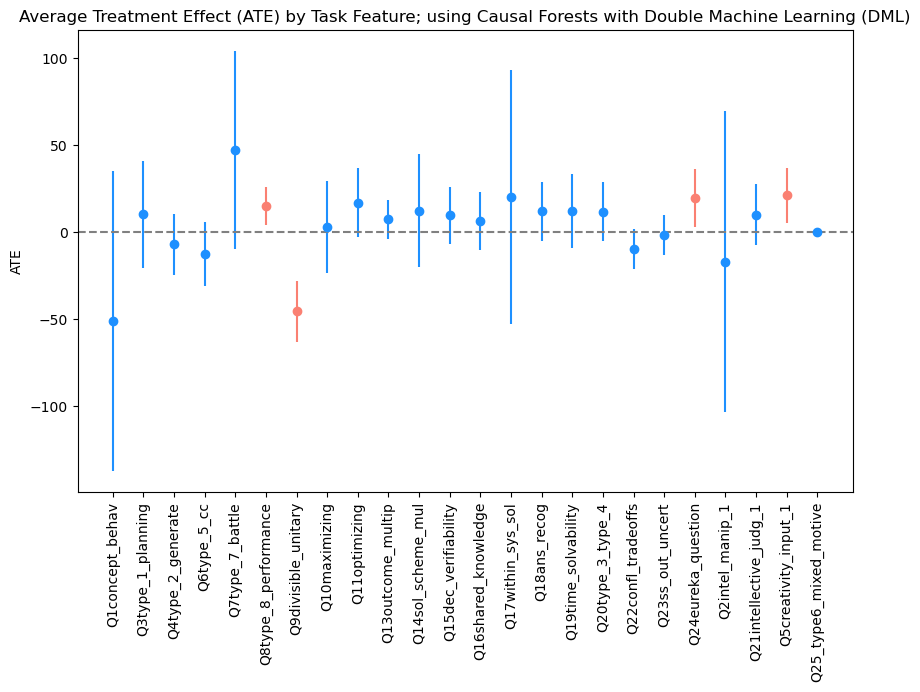

In [162]:
plt.figure(figsize=(10, 6))
for index, row in df_ate_by_task_feature.iterrows():
    # Check if the confidence interval does not include 0; color differently based on that
    if row['ATE_lb'] > 0 or row['ATE_ub'] < 0:
        plt.errorbar(row['Task Feature'], row['ATE'], yerr=[[row['ATE'] - row['ATE_lb']], [row['ATE_ub'] - row['ATE']]], fmt='o', color='salmon')
    else:
        plt.errorbar(row['Task Feature'], row['ATE'], yerr=[[row['ATE'] - row['ATE_lb']], [row['ATE_ub'] - row['ATE']]], fmt='o', color='dodgerblue')

plt.xticks(rotation=90)
plt.axhline(y=0, color='gray', linestyle='--')
plt.ylabel('ATE')
plt.title('Average Treatment Effect (ATE) by Task Feature; using Causal Forests with Double Machine Learning (DML)')
plt.show()

In [169]:
def get_task_feature_importances(task_feature, tree_depth=3, min_samples_leaf=10):
    est = CausalForestDML(model_y=GradientBoostingRegressor(),
                      model_t=GradientBoostingRegressor())
    est.tune(score_dv_train, task_treatment_train[task_feature], X=composition_covariates_train, W=None)
    est.fit(score_dv_train, task_treatment_train[task_feature], X=composition_covariates_train, W=None)
    """
    From: https://econml.azurewebsites.net/spec/interpretability.html
    SingleTreeCateInterpreter trains a single shallow decision tree for the treatment effect 
    you learned from any of our available CATE estimators on a small set of feature 
    that you are interested to learn heterogeneity from. The model will split on the cutoff points 
    that maximize the treatment effect difference in each leaf. Finally each leaf will be a subgroup of samples that 
    respond to a treatment differently from other leaves.
    """
    intrp = SingleTreeCateInterpreter(include_model_uncertainty=True, max_depth=tree_depth, min_samples_leaf=min_samples_leaf)
    # We interpret the CATE model's behavior based on the features used for heterogeneity
    intrp.interpret(est, composition_covariates_train)
    # Plot the tree
    plt.figure(figsize=(25, 10))
    intrp.plot(feature_names=composition_covariates_train.columns, fontsize=12)
    plt.show()

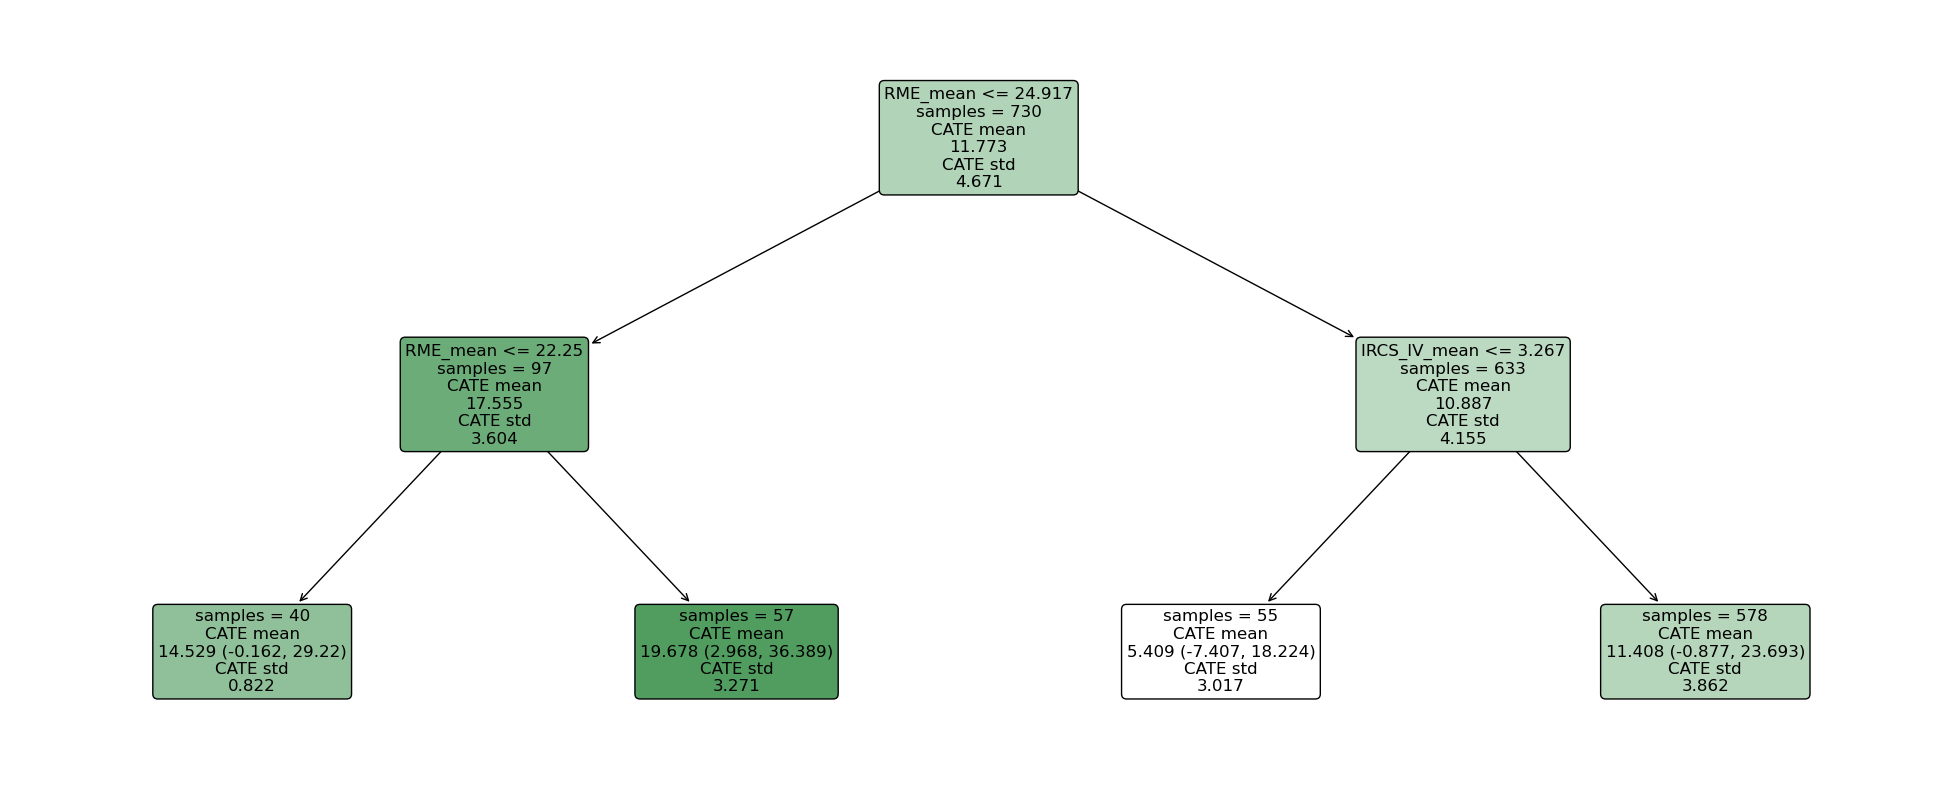

In [170]:
get_task_feature_importances("Q8type_8_performance", tree_depth=2)

# https://github.com/py-why/EconML
# NOTE: "True" goes to the left and "False" goes to the right!

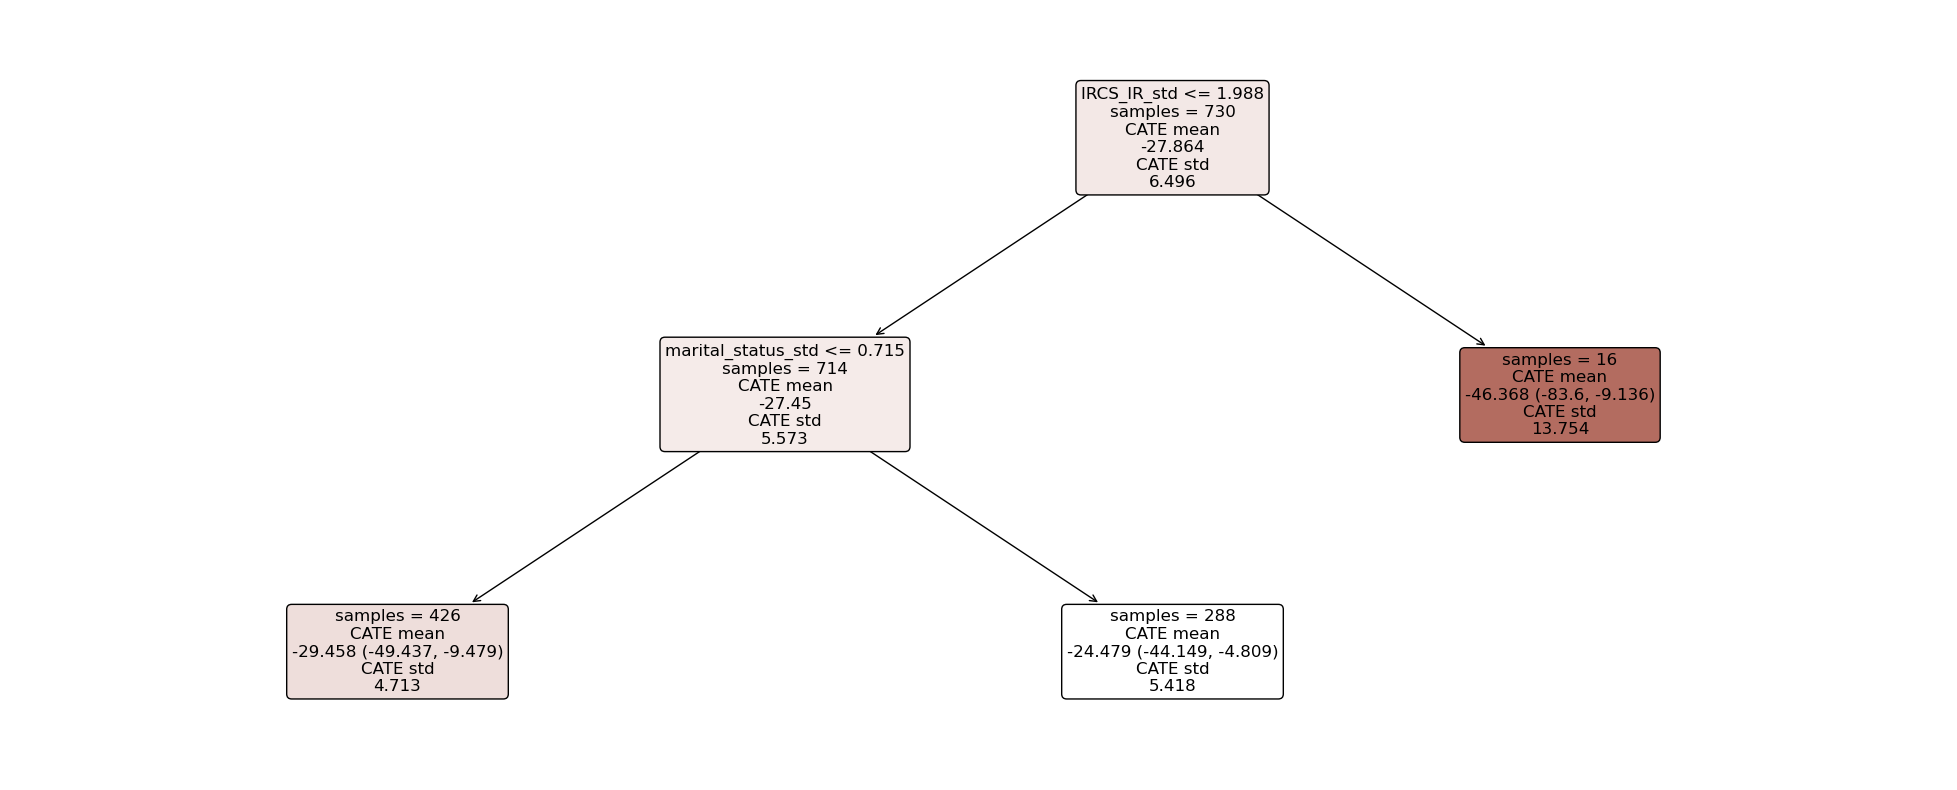

In [171]:
get_task_feature_importances("Q9divisible_unitary", tree_depth=2)

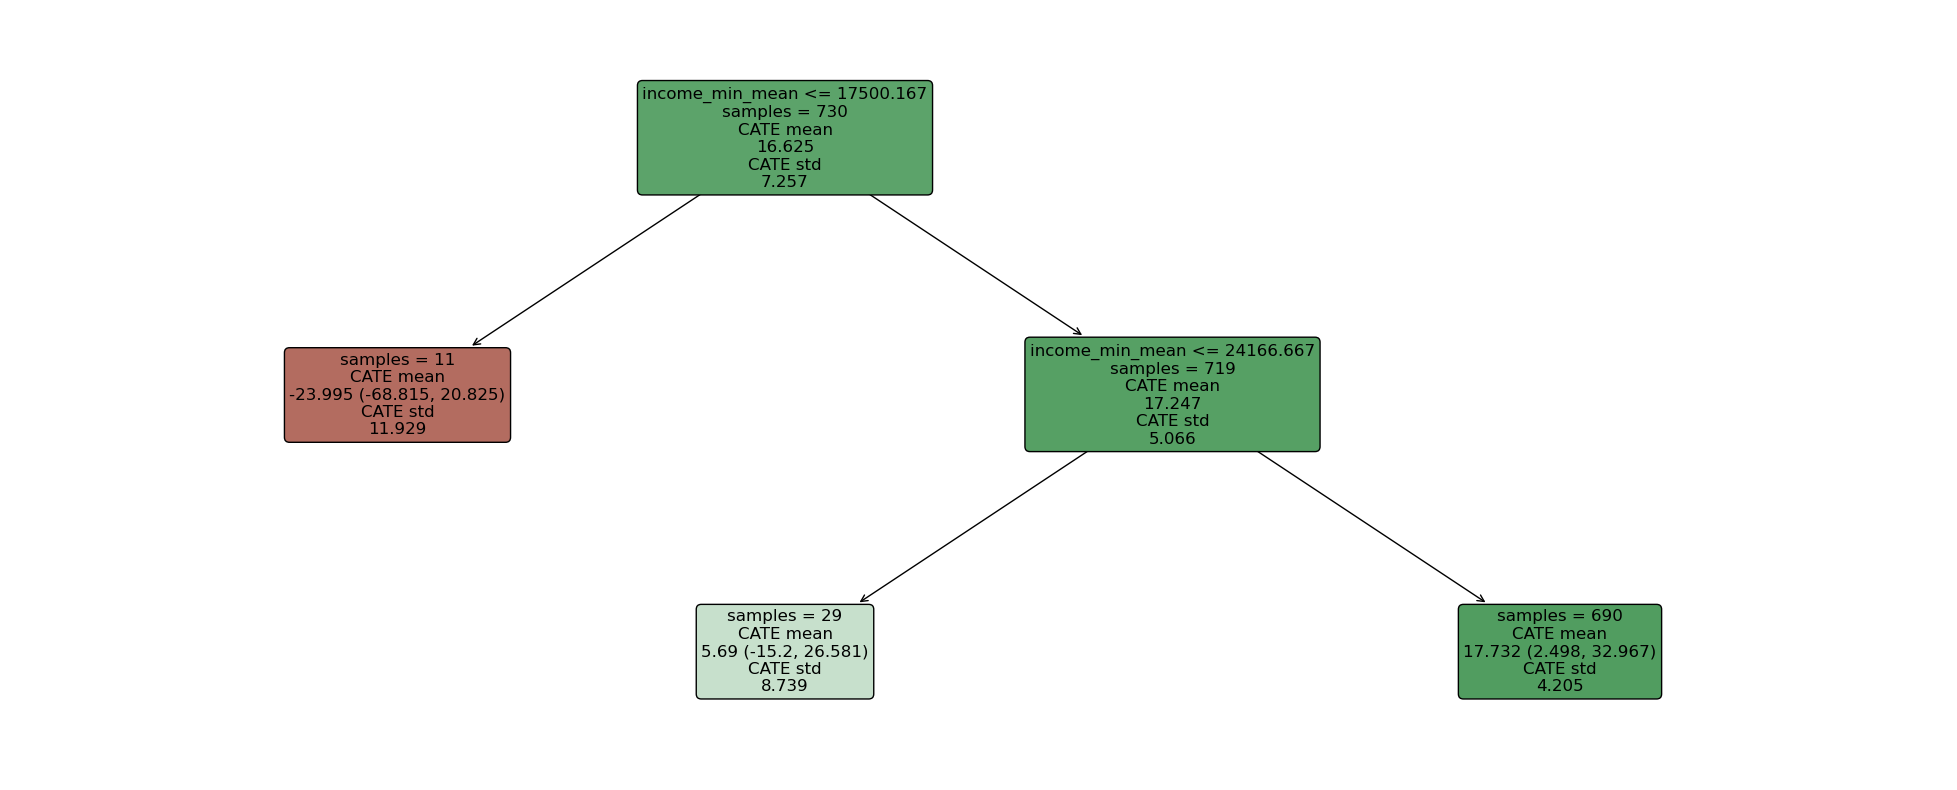

In [172]:
get_task_feature_importances("Q5creativity_input_1", tree_depth=2)

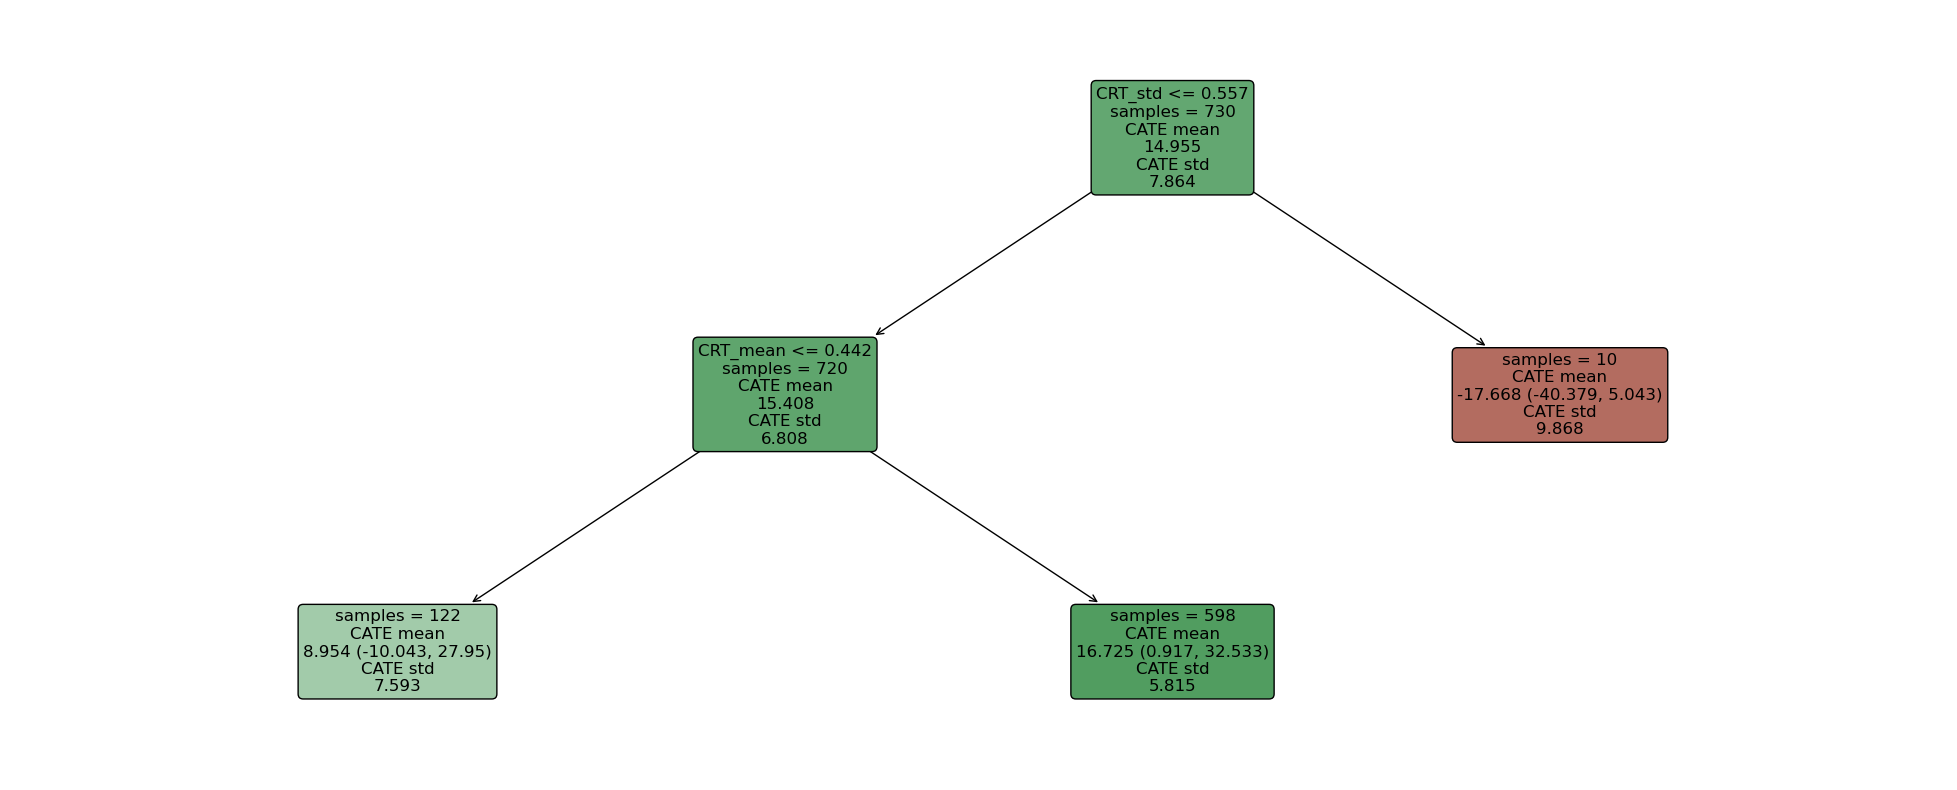

In [173]:
get_task_feature_importances("Q24eureka_question", tree_depth=2)

In [174]:
def get_covariate_importances_for_task_feature(task_feature):
    est = CausalForestDML(model_y=GradientBoostingRegressor(),
                      model_t=GradientBoostingRegressor())
    est.tune(score_dv_train, task_treatment_train[task_feature], X=composition_covariates_train, W=None)
    est.fit(score_dv_train, task_treatment_train[task_feature], X=composition_covariates_train, W=None)
    """
    The feature importances based on the amount of parameter heterogeneity they create. The higher, the more important the feature. 
    The importance of a feature is computed as the (normalized) total heterogeneity that the feature creates. Each split that the feature was chosen adds:
    parent_weight * (left_weight * right_weight)
        * mean((value_left[k] - value_right[k])**2) / parent_weight**2
    to the importance of the feature. Each such quantity is also weighted by the depth of the split. By default splits below max_depth=4 
    are not used in this calculation and also each split at depth depth, is re-weighted by 1 / (1 + depth)**2.0. See the method feature_importances
    for a method that allows one to change these defaults.
    """
    return pd.DataFrame({"covariate": composition_covariates_train.columns,
    "importance": est.feature_importances_}).sort_values(by = "importance", ascending = False)

In [175]:
get_covariate_importances_for_task_feature("Q24eureka_question")

,covariate,importance
3,CRT_std,0.059387
2,CRT_mean,0.056830
29,education_level_std,0.053814
0,birth_year_mean,0.052037
13,IRCS_IB_std,0.045213
10,IRCS_GV_mean,0.039735
1,birth_year_std,0.039316
21,political_fiscal_std,0.033884
16,IRCS_IV_mean,0.033057
7,income_min_std,0.031955


## Implementation 2: Team Composition as Treatments, Tasks as Covariates

This is an equivalent version of the problem, except we swap the treatments and the covariates. It might also make more sense; the idea is that the task is a fixed "background variable," and managers choose which team members to assign to which tasks.

In [178]:
composition_feature_ates = []
composition_feature_ate_lb = []
composition_feature_ate_ub = []

for composition_feature in composition_covariates.columns:

    # fit a causal forest model to estimate the average treatment effect of a task "treatment"
    est = CausalForestDML(model_y=GradientBoostingRegressor(),
                      model_t=GradientBoostingRegressor())
    est.tune(score_dv_train, composition_covariates_train[composition_feature], X=task_treatment_train, W=None)
    est.fit(score_dv_train, composition_covariates_train[composition_feature], X=task_treatment_train, W=None)
    
    ate = est.marginal_ate(composition_covariates_test[composition_feature], X=task_treatment_test)
    ate_interval = est.ate_interval(X=task_treatment_test)

    composition_feature_ates.append(ate)
    composition_feature_ate_lb.append(ate_interval[0])
    composition_feature_ate_ub.append(ate_interval[1])

In [179]:
ate_by_composition_feature = {'Composition Feature': composition_covariates.columns,
        'ATE': composition_feature_ates,
        'ATE_lb': composition_feature_ate_lb,
        'ATE_ub': composition_feature_ate_ub}

df_ate_by_composition_feature = pd.DataFrame(ate_by_composition_feature)
df_ate_by_composition_feature.sort_values(by = 'ATE', ascending = False)

,Composition Feature,ATE,ATE_lb,ATE_ub
2,CRT_mean,20.495680,-4.826772,45.818132
26,country_mean,10.287786,-11.740132,32.315705
36,race_mean,5.871244,-10.453113,22.195602
31,gender_std,5.609239,-10.851211,22.069689
28,education_level_mean,3.460542,-6.917945,13.839030
13,IRCS_IB_std,1.104278,-16.460919,18.669474
10,IRCS_GV_mean,1.035117,-6.333675,8.403909
24,RME_mean,1.032605,-0.833973,2.899183
38,playerCount,0.760108,-2.870725,4.390940
21,political_fiscal_std,0.721591,-62.037761,63.480943


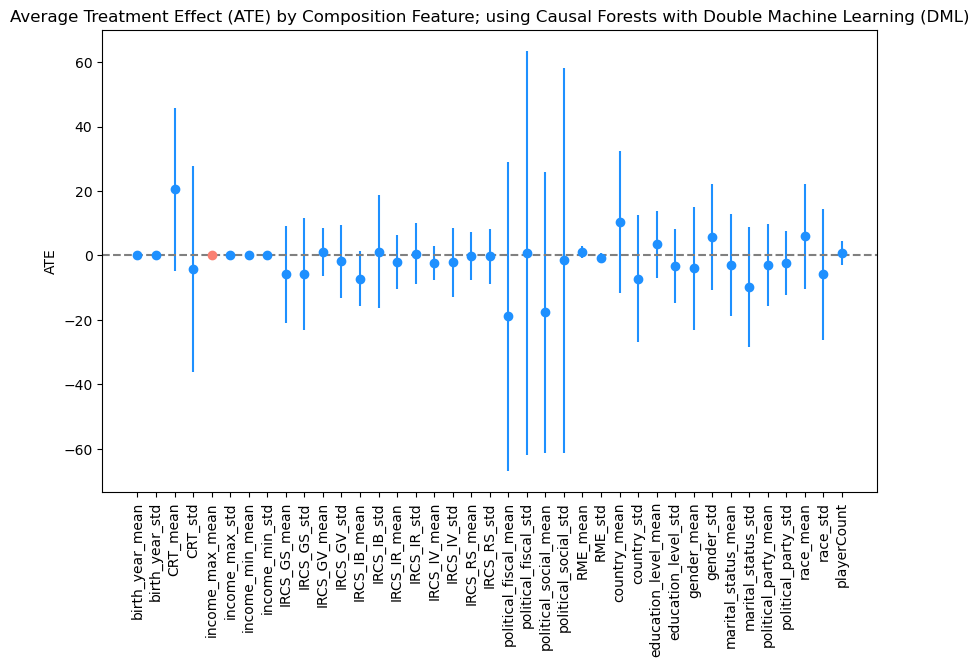

In [181]:
plt.figure(figsize=(10, 6))
for index, row in df_ate_by_composition_feature.iterrows():
    # Check if the confidence interval does not include 0; color differently based on that
    if row['ATE_lb'] > 0 or row['ATE_ub'] < 0:
        plt.errorbar(row['Composition Feature'], row['ATE'], yerr=[[row['ATE'] - row['ATE_lb']], [row['ATE_ub'] - row['ATE']]], fmt='o', color='salmon')
    else:
        plt.errorbar(row['Composition Feature'], row['ATE'], yerr=[[row['ATE'] - row['ATE_lb']], [row['ATE_ub'] - row['ATE']]], fmt='o', color='dodgerblue')

plt.xticks(rotation=90)
plt.axhline(y=0, color='gray', linestyle='--')
plt.ylabel('ATE')
plt.title('Average Treatment Effect (ATE) by Composition Feature; using Causal Forests with Double Machine Learning (DML)')
plt.show()

In [196]:
def get_composition_feature_importances(composition_feature, tree_depth=3, min_samples_leaf=10):
    est = CausalForestDML(model_y=GradientBoostingRegressor(),
                      model_t=GradientBoostingRegressor())
    est.tune(score_dv_train, composition_covariates_train[composition_feature], X=task_treatment_train, W=None)
    est.fit(score_dv_train, composition_covariates_train[composition_feature], X=task_treatment_train, W=None)
    
    intrp = SingleTreeCateInterpreter(include_model_uncertainty=True, max_depth=tree_depth, min_samples_leaf=min_samples_leaf)
    # We interpret the CATE model's behavior based on the features used for heterogeneity
    intrp.interpret(est, task_treatment_train)
    # Plot the tree
    plt.figure(figsize=(25, 10))
    intrp.plot(feature_names=task_treatment_train.columns, fontsize=12)
    plt.show()

In [202]:
def get_covariate_importances_for_task_feature(composition_feature):
    est = CausalForestDML(model_y=GradientBoostingRegressor(),
                      model_t=GradientBoostingRegressor())
    est.tune(score_dv_train, composition_covariates_train[composition_feature], X=task_treatment_train, W=None)
    est.fit(score_dv_train, composition_covariates_train[composition_feature], X=task_treatment_train, W=None)
    return pd.DataFrame({"covariate": task_treatment_train.columns,
    "importance": est.feature_importances_}).sort_values(by = "importance", ascending = False)

Here we might be getting at something: Having a higher CRT has a higher "treatment effect" when the question is a 'Eureka' question, adn when it is not divisible...

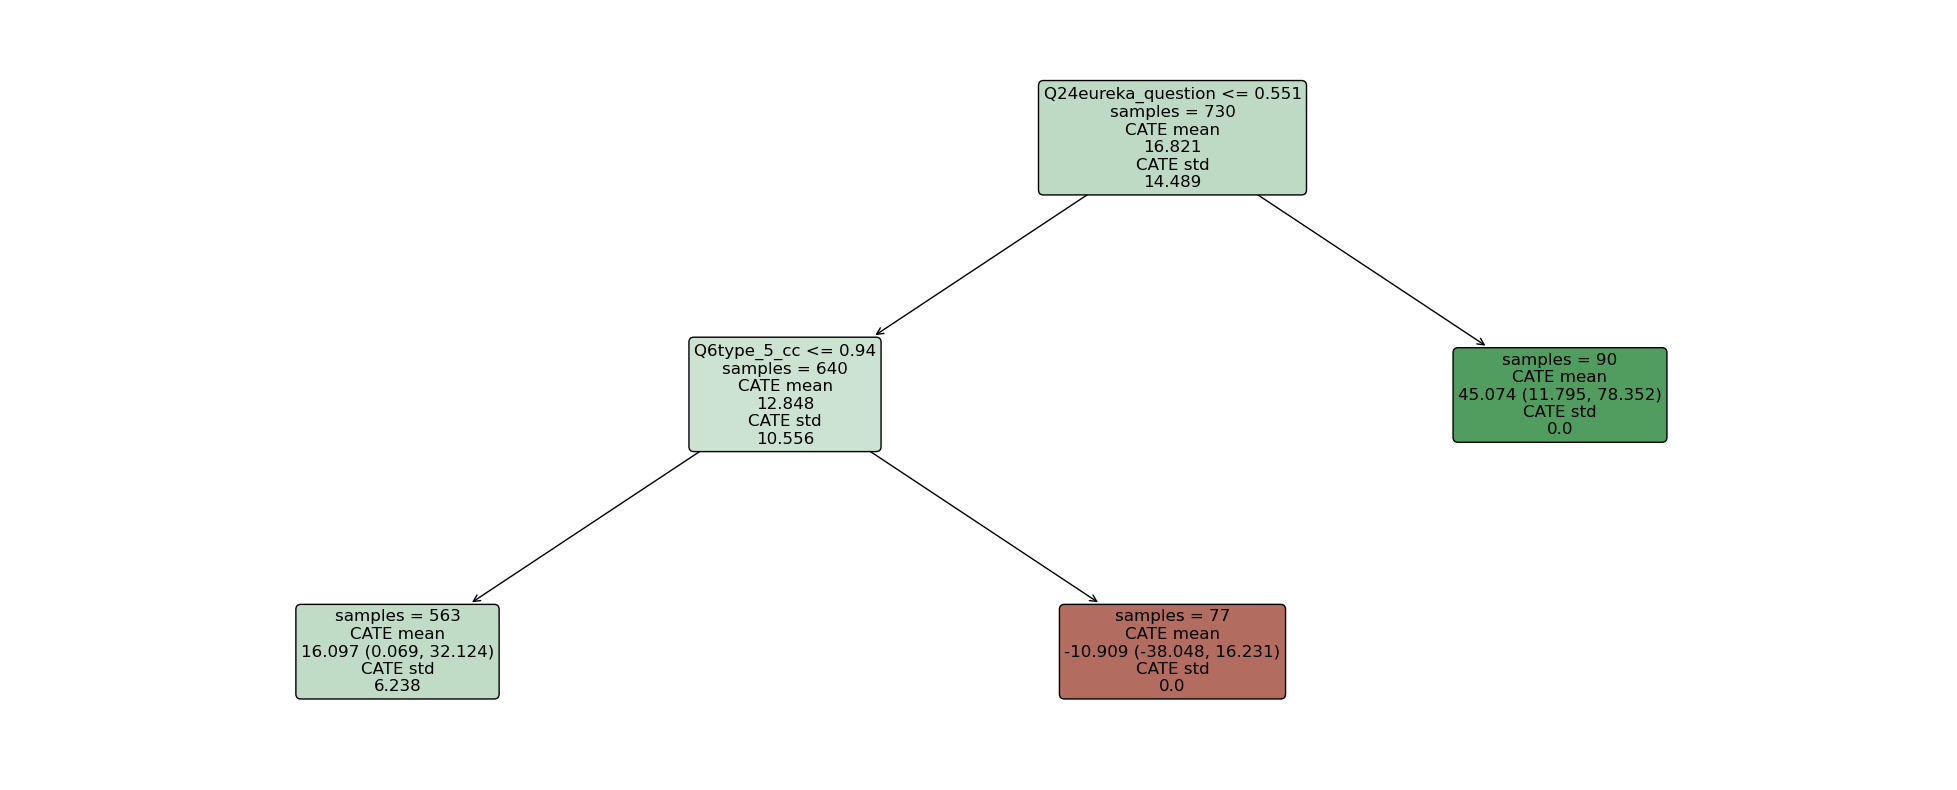

In [314]:
get_composition_feature_importances("CRT_mean", tree_depth=2)

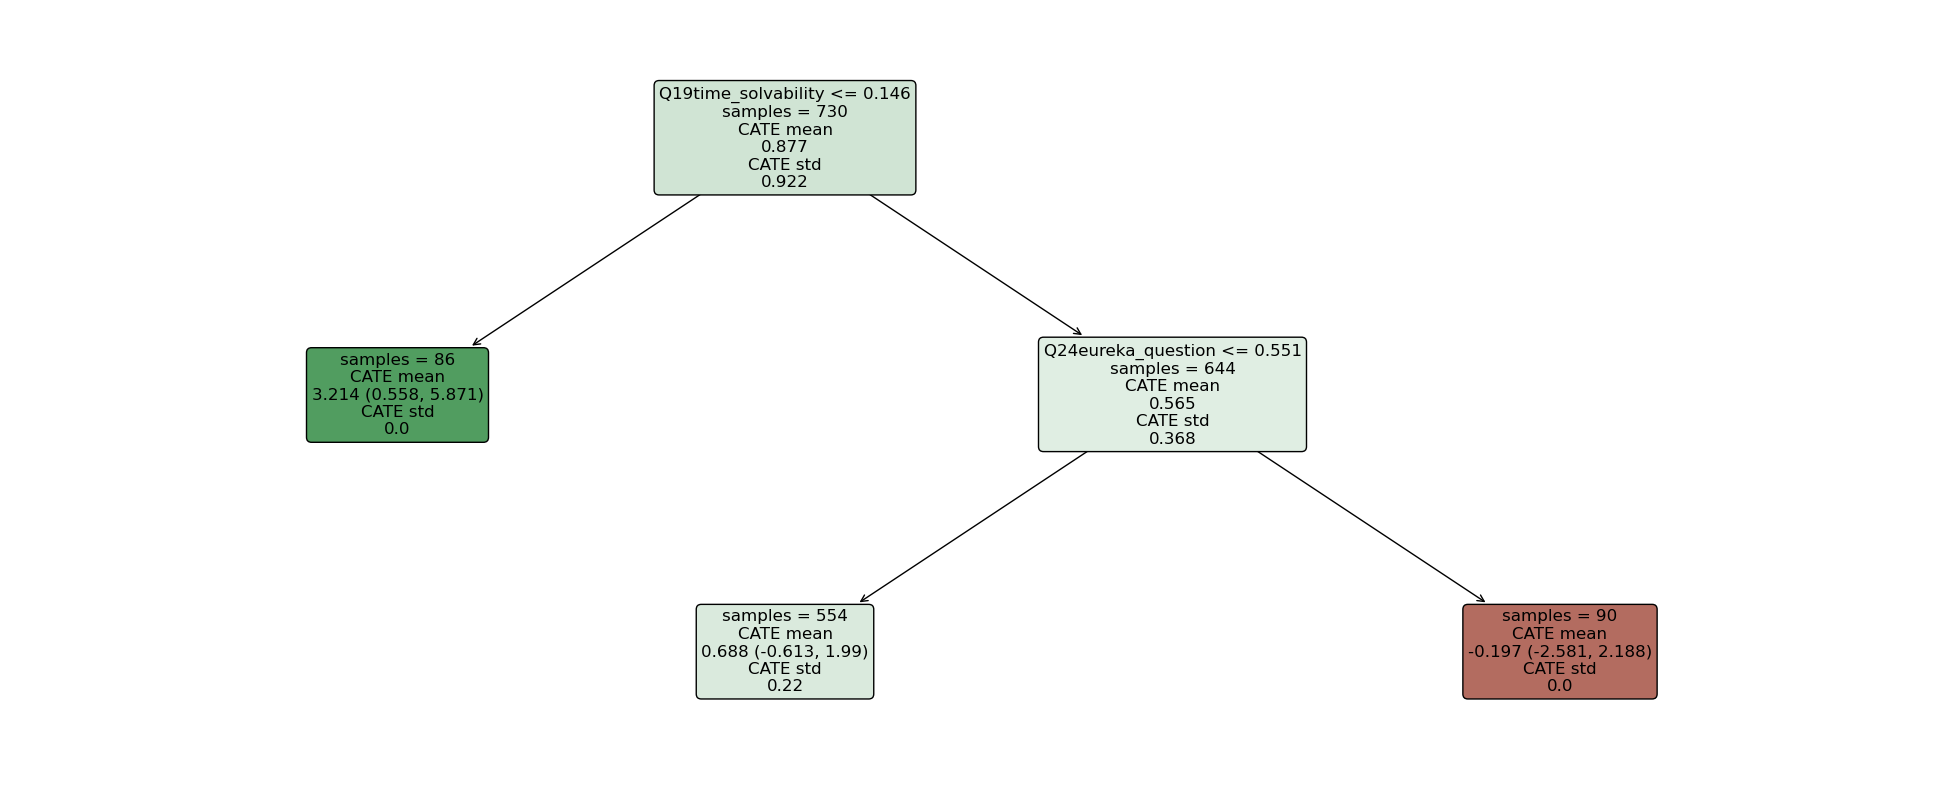

In [309]:
get_composition_feature_importances("RME_mean", tree_depth=2)

TODO: how do you know the direction of the importance, and whether it's 'significant' or not?

- This is important especially because we know that some covariates are correlated, so you can't interpret too much in the trees; there are many 'equally good' trees that can be created from similar splits

In [223]:
# Inference results for the quantities Tau(X, T0, T1)
# produced by the model. Available only when inference is not None, when calling the fit method.
est.effect_inference(task_treatment_train).summary_frame(alpha=0.05).head(10)

,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
X,,,,,,
0,0.388,1.194,0.325,0.745,-1.952,2.728
1,0.974,1.191,0.818,0.413,-1.359,3.308
2,3.327,1.676,1.985,0.047,0.043,6.612
3,0.974,1.191,0.818,0.413,-1.359,3.308
4,0.974,1.191,0.818,0.413,-1.359,3.308
5,-4.020,3.708,-1.084,0.278,-11.288,3.247
6,3.327,1.676,1.985,0.047,0.043,6.612
7,0.388,1.194,0.325,0.745,-1.952,2.728
8,2.698,2.149,1.255,0.209,-1.514,6.910


In [234]:
# Calculate the heterogeneous marginal effect \delta_T(T,X)
# The marginal effect is calculated around a base treatment point conditional on a vector of features on a set of m test samples 
# If treatment_featurizer is None, the base treatment is ignored in this calculation and the result 
# is equivalent to const_marginal_effect.
est.marginal_effect(X = task_treatment_train, T = composition_covariates_train[composition_feature])

array([ 0.38808495,  0.97442574,  3.32725759,  0.97442574,  0.97442574,
       -4.02038547,  3.32725759,  0.38808495,  2.69806474,  2.69806474,
        0.64380401,  1.30629968,  3.32725759,  0.97442574,  0.38808495,
        1.30629968,  2.69806474,  3.32725759, -4.02038547,  0.38808495,
        0.64380401,  0.64380401,  0.64380401,  3.32725759,  1.97749686,
       -4.02038547,  2.69806474, -1.76558985,  0.38808495,  0.64380401,
       -4.02038547,  0.38808495, -4.02038547,  3.32725759,  2.69806474,
        1.30629968,  1.30629968,  1.30629968,  0.97442574, -0.26094247,
        0.64380401, -4.02038547,  3.32725759,  1.97749686,  1.30629968,
       -4.02038547,  0.38808495,  2.69806474,  0.38808495,  0.38808495,
        1.30629968,  2.69806474, -4.02038547,  0.97442574,  0.64380401,
        3.32725759,  1.97749686,  2.69806474,  1.30629968,  0.38808495,
        0.97442574,  0.64380401,  1.97749686,  0.38808495,  2.69806474,
       -0.26094247, -4.02038547, -0.26094247,  1.30629968,  1.30

In [225]:
# TODO: what is the T0/T1 here? 
# T0 ((m, d_t) matrix or vector of length m, default 0) – Base treatments for each sample
# T1 ((m, d_t) matrix or vector of length m, default 1) – Target treatments for each sample
est.effect_inference(task_treatment_train, T1=composition_covariates_train[composition_feature]).summary_frame(alpha=0.05).head(10)

,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
X,,,,,,
0,1.164,3.581,0.325,0.745,-5.855,8.183
1,5.847,7.145,0.818,0.413,-8.157,19.850
2,19.964,10.055,1.985,0.047,0.255,39.672
3,5.847,7.145,0.818,0.413,-8.157,19.850
4,2.923,3.572,0.818,0.413,-4.078,9.925
5,-24.122,22.247,-1.084,0.278,-67.726,19.482
6,19.964,10.055,1.985,0.047,0.255,39.672
7,2.329,7.162,0.325,0.745,-11.709,16.366
8,16.188,12.894,1.255,0.209,-9.084,41.460


In [230]:
# Marginal treatment effects --- TODO --- what are these?
treatment_effect = est.const_marginal_effect(task_treatment_test)
te_upper, te_lower = est.const_marginal_effect_interval(task_treatment_test)

In [203]:
get_covariate_importances_for_task_feature("CRT_mean")

,covariate,importance
6,Q9divisible_unitary,0.123022
13,Q17within_sys_sol,0.112205
17,Q22confl_tradeoffs,0.109597
3,Q6type_5_cc,0.089028
1,Q3type_1_planning,0.088295
18,Q23ss_out_uncert,0.049606
2,Q4type_2_generate,0.043002
19,Q24eureka_question,0.042344
22,Q5creativity_input_1,0.040645
5,Q8type_8_performance,0.035545


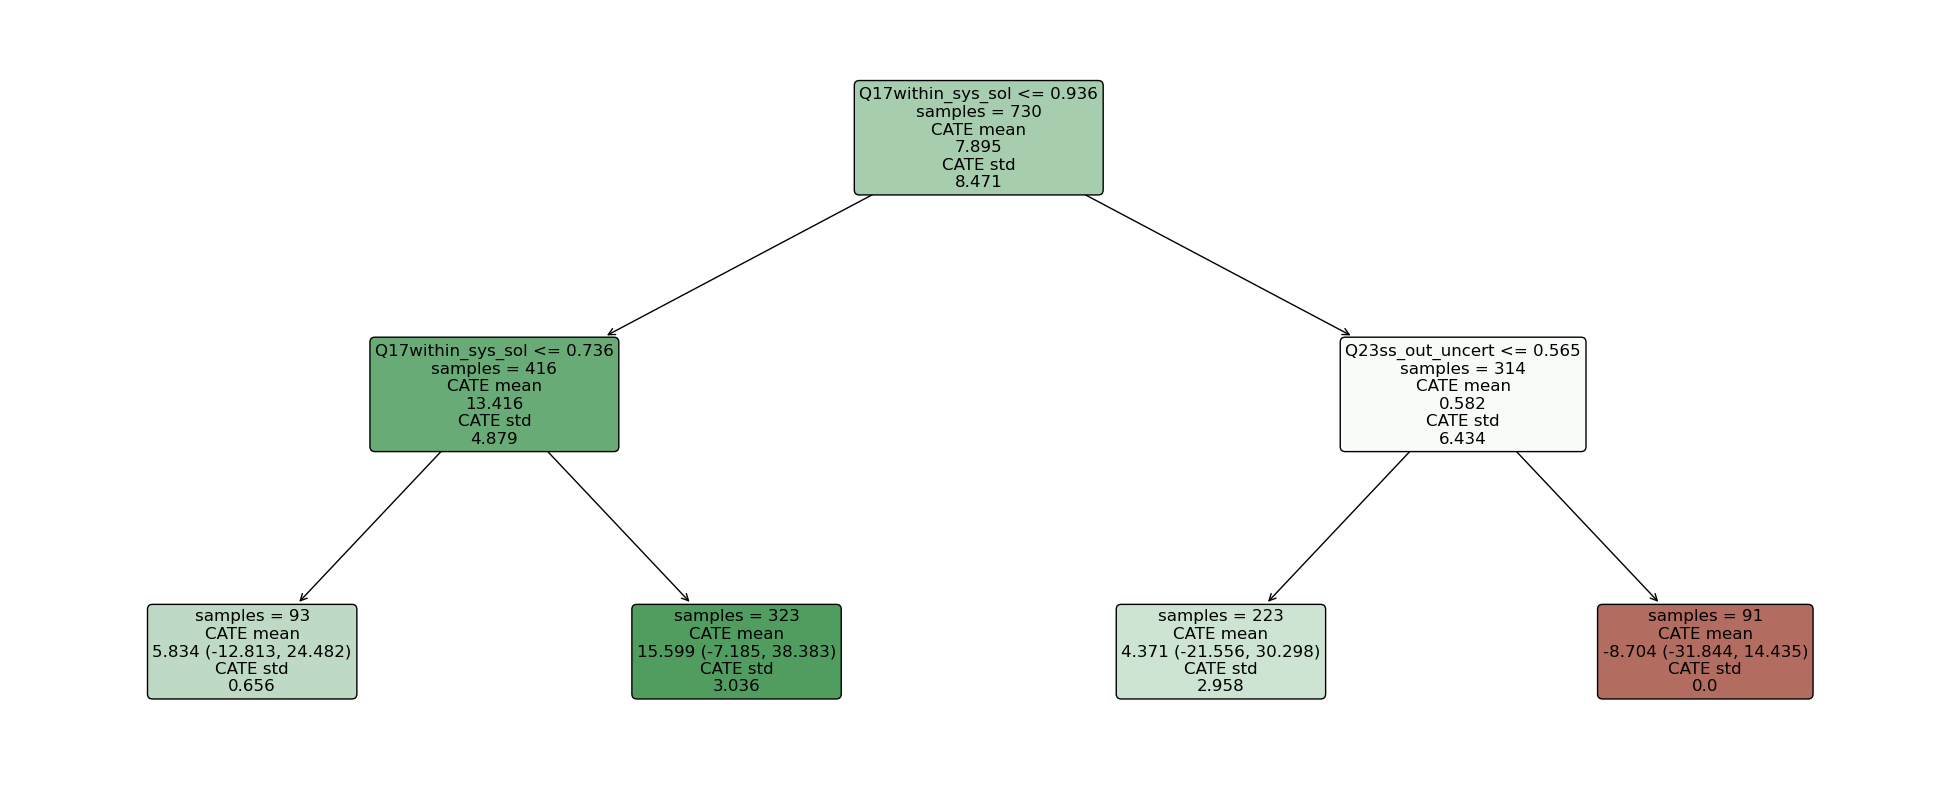

In [199]:
get_composition_feature_importances("country_mean", tree_depth=2)

In [204]:
get_covariate_importances_for_task_feature("country_mean")

,covariate,importance
1,Q3type_1_planning,0.118015
13,Q17within_sys_sol,0.087200
17,Q22confl_tradeoffs,0.083965
5,Q8type_8_performance,0.075130
18,Q23ss_out_uncert,0.072121
20,Q2intel_manip_1,0.066470
3,Q6type_5_cc,0.062221
6,Q9divisible_unitary,0.051828
8,Q11optimizing,0.051555
22,Q5creativity_input_1,0.047328


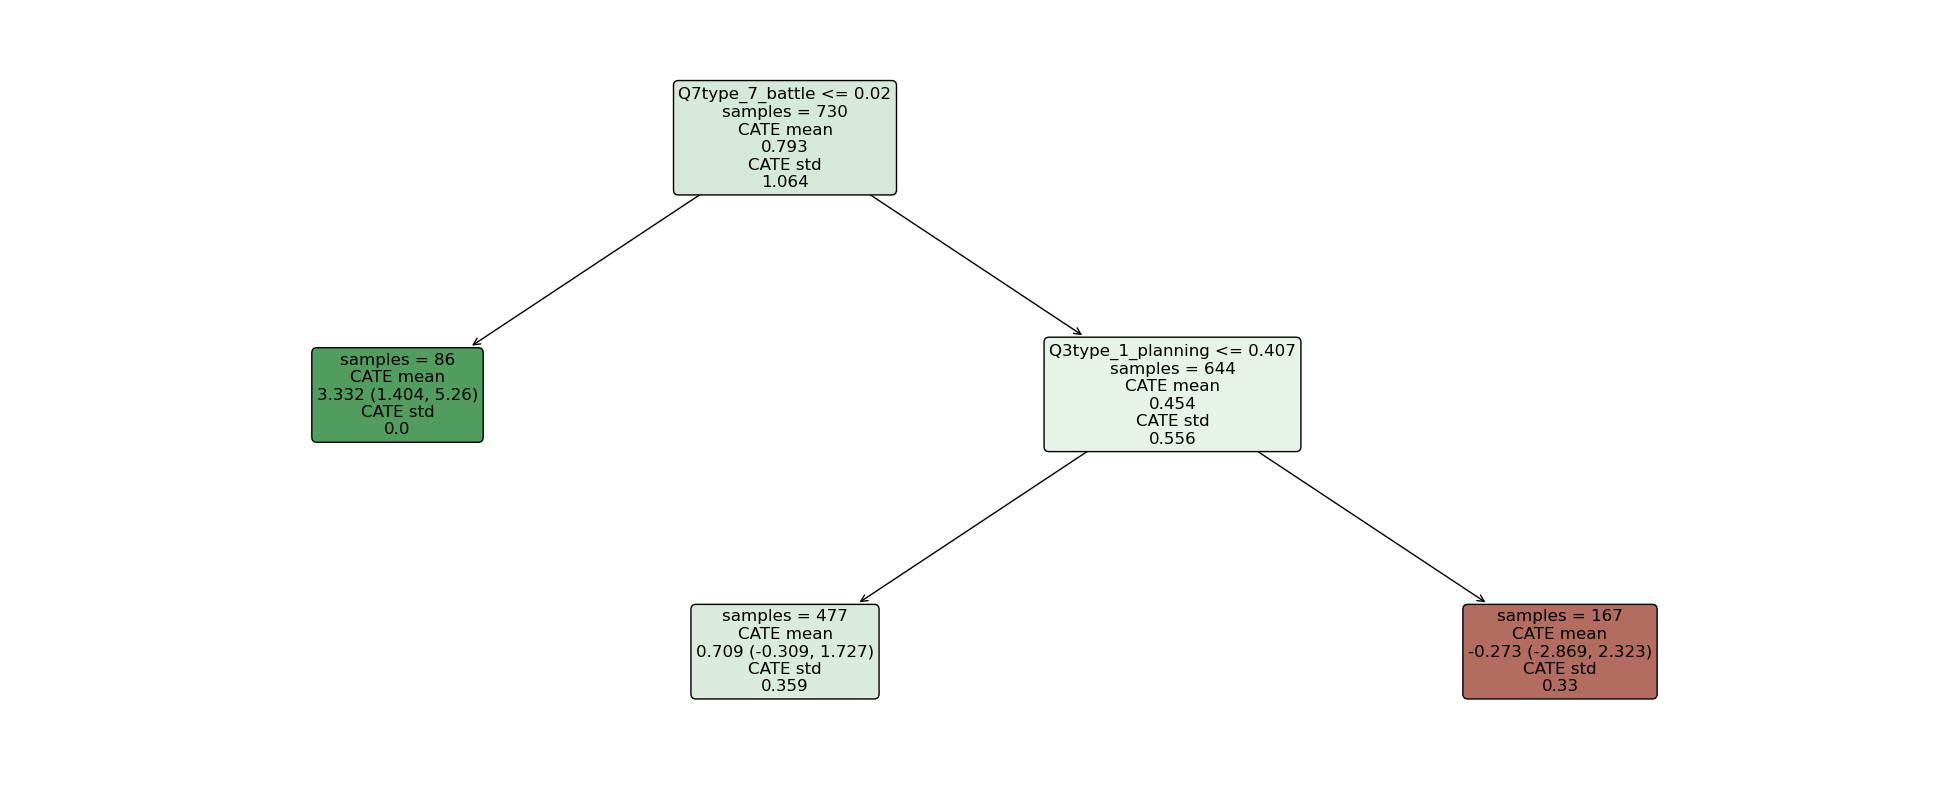

In [200]:
get_composition_feature_importances("RME_mean", tree_depth=2)

In [205]:
get_covariate_importances_for_task_feature("RME_mean")

,covariate,importance
3,Q6type_5_cc,0.114503
17,Q22confl_tradeoffs,0.114164
13,Q17within_sys_sol,0.113802
19,Q24eureka_question,0.078801
5,Q8type_8_performance,0.077290
1,Q3type_1_planning,0.073105
11,Q15dec_verifiability,0.047072
7,Q10maximizing,0.041797
6,Q9divisible_unitary,0.041357
22,Q5creativity_input_1,0.036426


# Attempting to Visualize the Marignals

In [384]:
df_task_feature_to_composition = pd.DataFrame(columns = composition_covariates.drop('country_mean', axis = 1).columns, index = task_treatment.drop(["Q25_type6_mixed_motive", "Q7type_7_battle"], axis = 1).columns)

for composition_factor in composition_covariates.drop('country_mean', axis = 1):
    for task_feature in task_treatment.drop(["Q25_type6_mixed_motive", "Q7type_7_battle"], axis = 1):
        # get the top 50% of the task feature (above 0.5)
        above_50_task_indices = task_treatment[task_feature] > 0.5
        above_50_task_covars = task_treatment[task_feature][above_50_task_indices]

        print("Number of teams who played a task with > 0.5 " + task_feature)
        print(len(above_50_task_covars))

        # now compute the difference between people who are ABOVE and BELOW mean on this composition attribute, GIVEN this task feature 
        
        # get the top 50% (above median) of the composition factor # TODO -- this is kind of a rough measure...
        composition_mean = np.median(composition_covariates[composition_factor]) if composition_factor != "playerCount" else 3
        top_half_indices = composition_covariates[composition_factor] > composition_mean
        # intersect top_half_indices with above_50_task_indices
        top_half_indices = top_half_indices & above_50_task_indices
        top_half_score = score_dv[top_half_indices]

        bottom_half_indices = composition_covariates[composition_factor] <= composition_mean
        bottom_half_indices = bottom_half_indices & above_50_task_indices
        bottom_half_score = score_dv[bottom_half_indices]

        # now compute the difference between the top and bottom half of the composition factor
        mean_score_differential = np.mean(top_half_score) - np.mean(bottom_half_score)

        df_task_feature_to_composition.loc[task_feature, composition_factor] = mean_score_differential

Number of teams who played a task with > 0.5 Q1concept_behav
19
Number of teams who played a task with > 0.5 Q3type_1_planning
129
Number of teams who played a task with > 0.5 Q4type_2_generate
152
Number of teams who played a task with > 0.5 Q6type_5_cc
246
Number of teams who played a task with > 0.5 Q8type_8_performance
247
Number of teams who played a task with > 0.5 Q9divisible_unitary
65
Number of teams who played a task with > 0.5 Q10maximizing
294
Number of teams who played a task with > 0.5 Q11optimizing
500
Number of teams who played a task with > 0.5 Q13outcome_multip
500
Number of teams who played a task with > 0.5 Q14sol_scheme_mul
267
Number of teams who played a task with > 0.5 Q15dec_verifiability
652
Number of teams who played a task with > 0.5 Q16shared_knowledge
584
Number of teams who played a task with > 0.5 Q17within_sys_sol
1043
Number of teams who played a task with > 0.5 Q18ans_recog
652
Number of teams who played a task with > 0.5 Q19time_solvability
652
Numbe

In [379]:
# Flatten the dataframe and drop NA values
data = df_task_feature_to_composition.to_numpy().flatten()
data = data[~np.isnan(data)]

quartiles = np.nanquantile(data, q=[0.05, 0.95])
print(quartiles)


[-9.10799851  8.22239197]


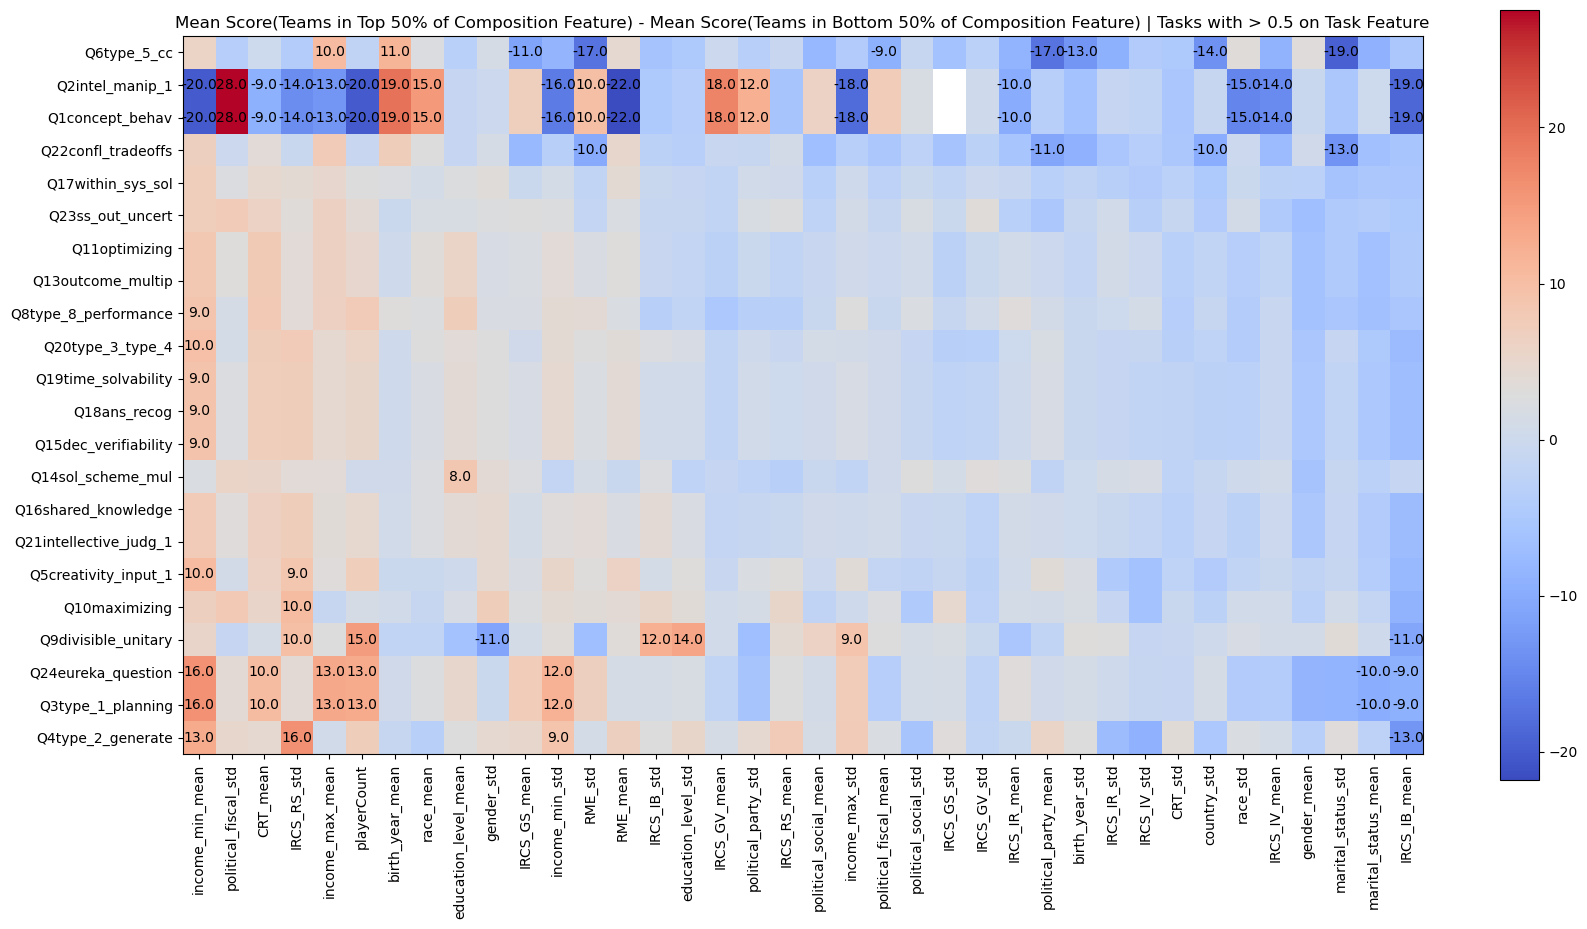

In [382]:
# Convert the data in df_task_feature_to_composition to float type
df_task_feature_to_composition = df_task_feature_to_composition.astype(float)
# sort df_task_feature_to_composition from greatest to least
df_task_feature_to_composition = df_task_feature_to_composition.reindex(df_task_feature_to_composition.mean().sort_values(ascending=False).index, axis=1)
# sort again, row-wise
df_task_feature_to_composition = df_task_feature_to_composition.reindex(df_task_feature_to_composition.mean(axis=1).sort_values(ascending=True).index, axis=0)

# Plot the heatmap
plt.figure(figsize=(20, 10))
plt.imshow(df_task_feature_to_composition, cmap='coolwarm', interpolation='nearest')
# if the value in the cell is smaller than quartiles[0] or larger than quartiles [1], print the value in the cell as a white text
for i in range(len(df_task_feature_to_composition.index)):
    for j in range(len(df_task_feature_to_composition.columns)):
        if df_task_feature_to_composition.iloc[i, j] < quartiles[0] or df_task_feature_to_composition.iloc[i, j] > quartiles[1]:
            plt.text(j, i, round(df_task_feature_to_composition.iloc[i, j], 0), ha='center', va='center', color='black')
plt.colorbar()
plt.xticks(range(len(df_task_feature_to_composition.columns)), df_task_feature_to_composition.columns, rotation = 90)
plt.yticks(range(len(df_task_feature_to_composition.index)), df_task_feature_to_composition.index)
plt.title('Mean Score(Teams in Top 50% of Composition Feature) - Mean Score(Teams in Bottom 50% of Composition Feature) | Tasks with > 0.5 on Task Feature')
plt.show()

# Not a Causal Forest, but what does an ElasticNet with Task + Composition Tell us?

In [244]:
optimal_elasticNet_params_path = "./model_eval_cache/optimal_params/stageId_noncumulative/task_attr_task_complexity_composition_size_ElasticNet_score_12"
with open(optimal_elasticNet_params_path, 'rb') as f:
    optimal_model = pickle.load(f)  # Load pickled data

In [250]:
optimal_params = optimal_model.optimal_parameters

In [251]:
ElasticNet_model = ElasticNet(alpha = optimal_params['alpha'], l1_ratio = optimal_params['l1_ratio'], max_iter=optimal_params['max_iter'], selection = optimal_params['selection'])

In [254]:
ElasticNet_model.fit(pd.concat([composition_covariates_train, task_treatment_train], axis = 1), score_dv_train)

ElasticNet(alpha=1.8780662134121764, l1_ratio=0.10436165500465526, max_iter=652)

In [260]:
pd.DataFrame({ "feature_names": ElasticNet_model.feature_names_in_,
                "coefficients": ElasticNet_model.coef_ }).sort_values(by = "coefficients", ascending = False).head(10)

,feature_names,coefficients
61,Q5creativity_input_1,0.801728
24,RME_mean,0.737008
47,Q11optimizing,0.654357
58,Q24eureka_question,0.578661
44,Q8type_8_performance,0.436532
50,Q15dec_verifiability,0.400739
38,playerCount,0.380839
40,Q3type_1_planning,0.358796
53,Q18ans_recog,0.322189
48,Q13outcome_multip,0.291149


In [274]:
n_bootstraps = 1000

coef_samples = []

# Bootstrap resampling and fitting ElasticNet model
for i in range(n_bootstraps):
    X_boot, y_boot = resample(pd.concat([composition_covariates, task_treatment], axis = 1), score_dv)
    model = ElasticNet(alpha = optimal_params['alpha'], l1_ratio = optimal_params['l1_ratio'], max_iter=optimal_params['max_iter'], selection = optimal_params['selection'])
    model.fit(X_boot, y_boot)
    coef_samples.append(model.coef_)

    if i % 100 == 0:
        print(f"Bootstrap iteration {i} completed.") 

# Calculate p-values
coef_means = np.nanmean(coef_samples, axis=0)
coef_stds = np.nanstd(coef_samples, axis=0)
z_scores = coef_means / coef_stds  # z-scores for coefficients
p_values = 2 * (1 - stats.norm.cdf(np.abs(z_scores)))  # two-tailed p-values
t_stats = coef_means / coef_stds

# Calculate 95% confidence intervals
ci_lower = coef_means - 1.96 * coef_stds
ci_upper = coef_means + 1.96 * coef_stds

Bootstrap iteration 0 completed.
Bootstrap iteration 100 completed.
Bootstrap iteration 200 completed.
Bootstrap iteration 300 completed.
Bootstrap iteration 400 completed.
Bootstrap iteration 500 completed.
Bootstrap iteration 600 completed.
Bootstrap iteration 700 completed.
Bootstrap iteration 800 completed.
Bootstrap iteration 900 completed.


In [284]:
results_df = pd.DataFrame({
    "Feature Names": list(composition_covariates.columns) + list(task_treatment.columns),  # Assuming column names are feature names
    "Coefficient": coef_means,
    "t-Statistic": t_stats,
    "P-value": np.round(p_values, 4),
    "95% CI Lower": ci_lower,
    "95% CI Upper": ci_upper
})

In [287]:
results_df.sort_values(by = "P-value", ascending = True).head(20)

,Feature Names,Coefficient,t-Statistic,P-value,95% CI Lower,95% CI Upper
61,Q5creativity_input_1,0.813352,8.042021,0.0000,0.615122,1.011582
58,Q24eureka_question,0.602514,5.087773,0.0000,0.370403,0.834625
42,Q6type_5_cc,-0.775655,-4.976404,0.0000,-1.081153,-0.470156
45,Q9divisible_unitary,-0.651759,-7.308302,0.0000,-0.826553,-0.476965
47,Q11optimizing,0.630199,5.431285,0.0000,0.402777,0.857620
44,Q8type_8_performance,0.417581,3.274121,0.0011,0.167603,0.667559
24,RME_mean,0.904786,3.222758,0.0013,0.354518,1.455054
50,Q15dec_verifiability,0.439291,3.187624,0.0014,0.169181,0.709402
40,Q3type_1_planning,0.354430,3.179542,0.0015,0.135945,0.572915
53,Q18ans_recog,0.356355,3.080454,0.0021,0.129617,0.583093


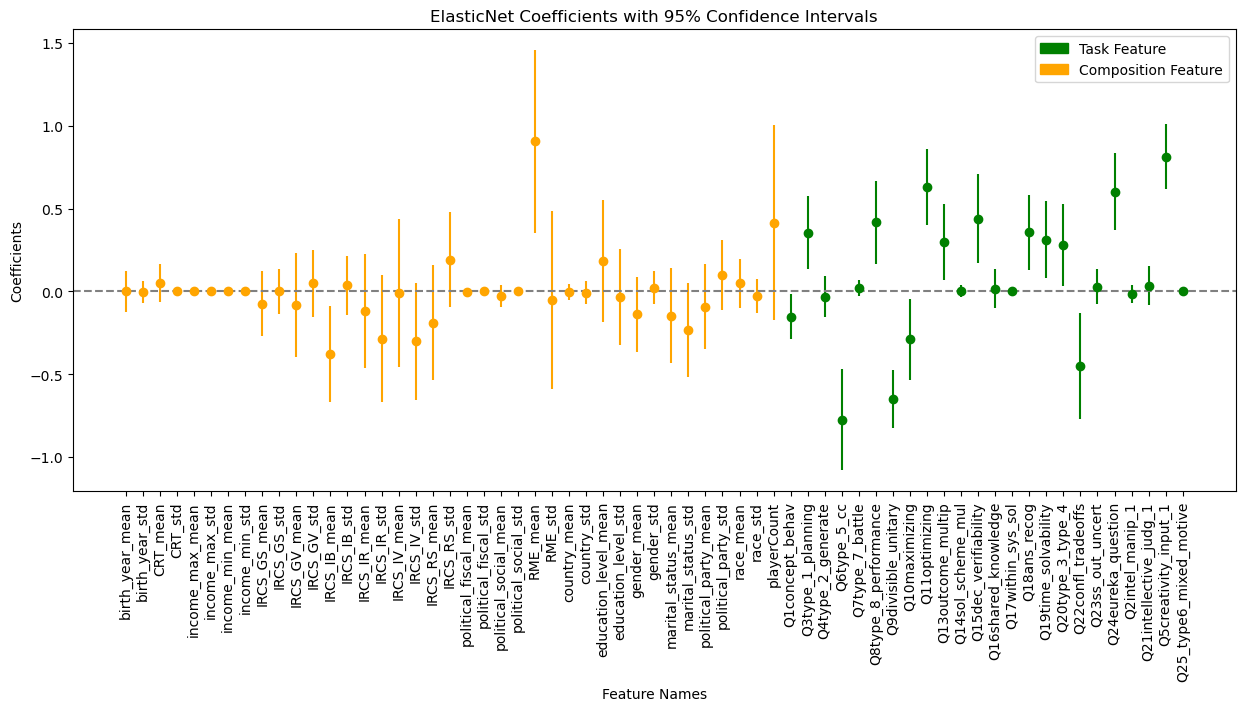

In [366]:
feature_names = results_df['Feature Names']
coefficients = results_df['Coefficient']

# Get the lower and upper bounds of the confidence interval
ci_lower = results_df['95% CI Lower']
ci_upper = results_df['95% CI Upper']

# Create a list of colors for the points
colors = ['green' if feature in task_treatment.columns else 'orange' for feature in feature_names]

plt.figure(figsize=(15, 6))
for feature, coef, ci_l, ci_u, color in zip(feature_names, coefficients, ci_lower, ci_upper, colors):
    plt.errorbar(feature, coef, yerr=[[coef - ci_l], [ci_u - coef]], fmt='o', color=color, capsize=0)
plt.xlabel('Feature Names')
plt.ylabel('Coefficients')
plt.title('ElasticNet Coefficients with 95% Confidence Intervals')
legend_handles = [
    mpatches.Patch(color='green', label='Task Feature'),
    mpatches.Patch(color='orange', label='Composition Feature')
]
plt.legend(handles=legend_handles, loc='upper right')
plt.axhline(y=0, color='gray', linestyle='--')
plt.xticks(rotation=90)
plt.show()

In [297]:
q2_evaluation_output = [ast.literal_eval(x.strip())["q^2"] for x in open(file_path, "r").readlines()]


In [298]:
np.mean(q2_evaluation_output)

0.17139591757634606